analyze saccade frequency and magnitude: draw v.s. click

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
import sys

def get_n_dir_up(path, n):
    for _ in range(n):
        path = os.path.dirname(path)
    return path

CUR_PATH= os.path.abspath("__file__")
sys.path.append(os.path.join(get_n_dir_up(CUR_PATH, 2)))

In [4]:
SACC_SRC_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 4), "data", "pilot", "saccade")

### subject filtering

In [5]:
import json

DEFAULT_DATA_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data')
with open(os.path.join(DEFAULT_DATA_FOLDER, 'QA.json')) as f:
    qa_records = json.load(f)

invalid_subjs = qa_records['invalid']

In [6]:
DEFAULT_FEATURE_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 2), 'gaze_analysis', 'features')
all_subjs = os.listdir(DEFAULT_FEATURE_FOLDER)
all_subjs = [subj for subj in all_subjs if subj.isdigit()]
all_subjs = [subj for subj in all_subjs if int(subj) not in invalid_subjs]

## Load And Preprocess Saccade Path

In [7]:
CLEANED_SACC_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), "data", "saccades")

In [8]:
BEHAV_FOLDER_PATH = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'data', 'behavior', 'batches')

In [9]:
from utils.eye_preprocess import convert_movement_to_angle
from utils.eye_data import create_xydata_from_df

def get_last_response(row):
    if pd.isna(row['resp_1_last_drawing_tend']) and pd.isna(row['resp_2_last_drawing_tend']):
        return np.nan
    elif pd.isna(row['resp_1_last_drawing_tend']):
        return row['resp_2']
    elif pd.isna(row['resp_2_last_drawing_tend']):
        return row['resp_1']
    else:
        return row['resp_2'] if row['resp_2_last_drawing_tend'] > row['resp_1_last_drawing_tend'] else row['resp_1']

def behav_df_add_last_response(df):
    df['current_last_response'] = df.apply(get_last_response, axis=1)
    df_copy = df[['participant', 'block', 'trial', 'current_last_response']].copy()
    df_copy['trial'] += 1  # Increment trial to match the next row's trial
    df_copy = df_copy.rename(columns={'current_last_response': 'prev_last_response'})
    df = df.merge(df_copy, on=['participant', 'block', 'trial'], how='left')
    return df

def align_saccade_with_behav(subj_sacc_df, subj_behav_df):
    loaded_xy = create_xydata_from_df(subj_sacc_df)
    # alogn the gaze data with the behavior data
    trial_ids = subj_behav_df['TRIALID'].values
    xs, ys, mask = loaded_xy.read(
        trial_ids=trial_ids, get_trial_mask=True)
    df = subj_behav_df[mask]
    return xs, ys, df

def convert_saccades_batch_data(batch_id):
    # load batch saccades
    saccade_df = pd.read_csv(
        os.path.join(SACC_SRC_FOLDER, f"{batch_id}.csv"))
    saccade_df = saccade_df.drop(
        columns=[col for col in saccade_df.columns if col.startswith("Unnamed")])
    # load behavior
    behav_df = pd.read_csv(
        os.path.join(BEHAV_FOLDER_PATH, f"{batch_id}.csv"))
    behav_df = behav_df.drop(
        columns=[col for col in behav_df.columns if col.startswith("Unnamed")])
    # pad data if necessary
    behav_df = behav_df_add_last_response(behav_df)
    # convert to xs, ys and df
    xs, ys, df = align_saccade_with_behav(saccade_df, behav_df)
    # convert to angles and magnitudes
    angles, mags = convert_movement_to_angle(
        xs, ys, epoch=360, compute_mag=True, stim_align=True)

    # save the result, per subject
    for subj_id in df['participant'].unique():
        subj_mask = (df['participant'] == subj_id).to_numpy()
        # svae behaviors
        subj_df = df[subj_mask]
        subj_df_path = os.path.join(
            CLEANED_SACC_FOLDER, 'behav', f"{subj_id}.csv")
        subj_df.to_csv(subj_df_path, index=False)
        # save saccades
        subj_angles = angles[subj_mask]
        subj_mags = mags[subj_mask]
        subj_angle_mag = np.stack([subj_angles, subj_mags], axis=-1)
        subj_angle_mag_path = os.path.join(
            CLEANED_SACC_FOLDER, 'cleaned', f"{subj_id}.npy")
        np.save(subj_angle_mag_path, subj_angle_mag)

        print(len(subj_df), subj_angle_mag.shape)


In [ ]:
def preprocess_saccades():
    for batch_id in [
        '908to915', '916to922', '927to937', '938to949','950to952',
    ]:
        convert_saccades_batch_data(batch_id)

preprocess_saccades()

157 (157, 10000, 2)
156 (156, 10000, 2)
158 (158, 10000, 2)


### Plot the frequency and magnitude

In [18]:
PLOTS_FOLDER = os.path.join(
    get_n_dir_up(CUR_PATH, 3), 'results', 'images', 'sacc')

In [19]:
def load_saccades(subj):
    # load behavior
    subj_behav_df = pd.read_csv(
        os.path.join(CLEANED_SACC_FOLDER, 'behav', f"{subj}.csv"))
    # load saccades
    subj_saccades = np.load(
        os.path.join(CLEANED_SACC_FOLDER, 'cleaned', f"{subj}.npy"))
    return subj_saccades, subj_behav_df

In [20]:
from utils.eye_plotting import annotate_time_line
from scipy.ndimage import convolve1d
from utils.eye_trial import generate_events

EVENTS = generate_events()
T_TOTAL = 10000
SACC_START = EVENTS['s1 onset']
SACC_END = EVENTS['response']

def collapse_saccades_mag(subj_mag, subj_df, lmb, is_binary=False):
    if is_binary:
        subj_mag = (subj_mag > 0).astype(float)

    # normalization
    subj_mag_max = np.quantile(subj_mag[subj_mag>0], 0.95)
    subj_mag = subj_mag / subj_mag_max
    subj_mag[subj_mag > 1] = 1 # remove outliers

    # masking
    if lmb is not None:
        mask = lmb(subj_df)
        subj_mag = subj_mag[mask]
            
    subj_mag_aggregated = np.mean(subj_mag, axis=0)

    # finally, mask out irrelevant part
    subj_mag_aggregated[:SACC_START] = 0
    subj_mag_aggregated[SACC_END:] = 0

    return subj_mag_aggregated

def collect_all_subj_sacc_mags(lmb, mag_normalize):
    collected = {}
    for subj in all_subjs:
        subj_sacc_data, subj_df = load_saccades(subj)
        subj_mags = subj_sacc_data[..., 1]
        collected[subj] = collapse_saccades_mag(
            subj_mags, subj_df, lmb, is_binary=mag_normalize)
    return collected

def plot_motion_mag_with_mask(ax, lmb, label=None, line_color='gray', mag_normalize=True, smooth_window=51):
    subj_mag_aggregated = collect_all_subj_sacc_mags(lmb, mag_normalize=mag_normalize)
    subj_mag_aggregated = [subj_mag_aggregated[k] for k in subj_mag_aggregated]
    subj_mag_aggregated = np.array(subj_mag_aggregated)

    # smoothing
    if smooth_window > 1:
        subj_mag_aggregated = convolve1d(
            subj_mag_aggregated, 
            np.ones(smooth_window)/smooth_window, 
            axis=1, mode='constant', cval=0.0)
            
    # plot it
    mean_mag = np.mean(subj_mag_aggregated, axis=0)
    sem_mag = np.std(subj_mag_aggregated, axis=0) / np.sqrt(len(subj_mag_aggregated))
    ax.plot(mean_mag, color=line_color, label=label)
    ax.fill_between(
        np.arange(T_TOTAL), 
        mean_mag-sem_mag, mean_mag+sem_mag, color=line_color, alpha=0.3)
    annotate_time_line(ax, EVENTS)

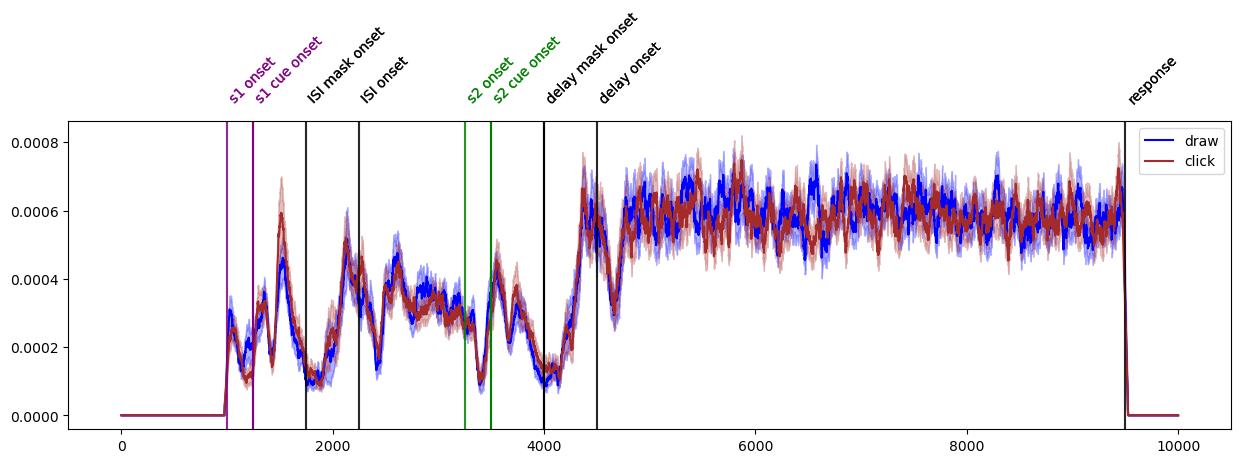

In [21]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color='blue', mag_normalize=False)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='click', line_color='brown', mag_normalize=False)
ax.legend()

plot_path = os.path.join(PLOTS_FOLDER, 'sacc_mag.png')
plt.savefig(plot_path)

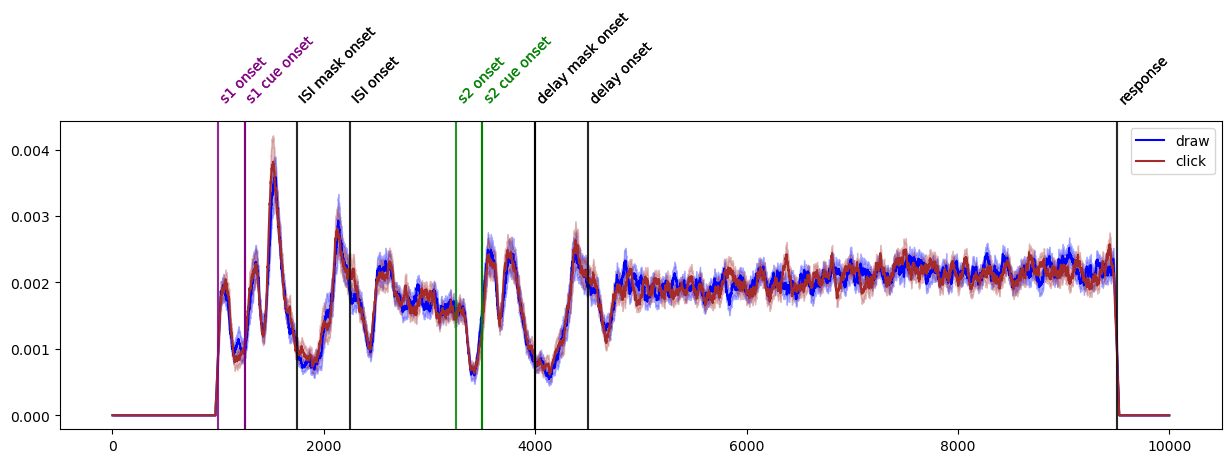

In [22]:
fig, ax = plt.subplots(1, figsize=(15, 4))
draw_lmb = lambda d: (d['mode'] == 'draw').to_numpy()
plot_motion_mag_with_mask(ax, draw_lmb, label='draw', line_color='blue', mag_normalize=True)
click_lmb = lambda d: (d['mode'] == 'click').to_numpy()
plot_motion_mag_with_mask(ax, click_lmb, label='click', line_color='brown', mag_normalize=True)
ax.legend()

plot_path = os.path.join(PLOTS_FOLDER, 'sacc_freq.png')
plt.savefig(plot_path)

**comment**: no significant difference...